# [Amet Vikram]
# Programming Exercise \#4
---

# Preamble

In [ ]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

In [1]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

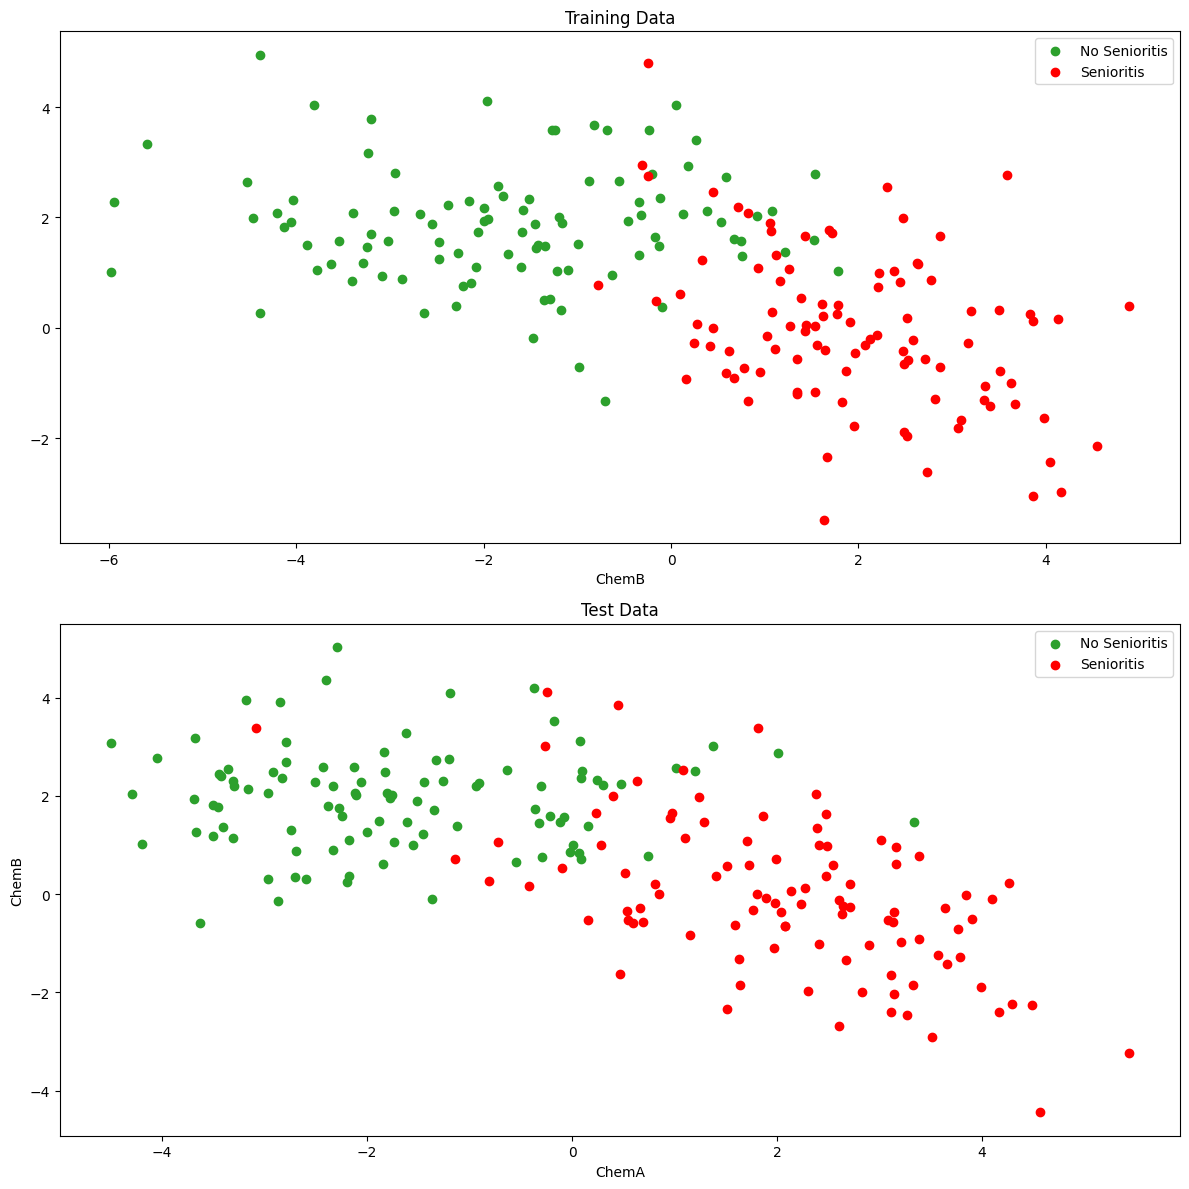

In [2]:
df_train = pd.read_csv("SenioritisTrainingData.csv")
df_test = pd.read_csv("SenioritisTestData.csv")

groupby_train = df_train.groupby("ClassLabel")
groupby_test = df_test.groupby("ClassLabel")

fig, ax = plt.subplots(2, 1, figsize=(12,12))

class_labels = groupby_train.groups.keys()

ax[0].set_title("Training Data")
ax[0].set_xlabel("ChemA")
ax[0].set_xlabel("ChemB")
for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax[0].scatter(x,y,c=color)
ax[0].legend(class_labels)

ax[1].set_title("Test Data")
ax[1].set_xlabel("ChemA")
ax[1].set_ylabel("ChemB")
for label in class_labels:
    x = groupby_test.get_group(label)["ChemA"]
    y = groupby_test.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax[1].scatter(x,y,c=color)
ax[1].legend(class_labels)

plt.tight_layout()
plt.show()

## Problem 1.2

### (a)

In [3]:
## Now for LDA, we know as it is a plugin MAP classifier
## with different means but same covariance matrix, where
## the likelihood functions are Gaussian, and so we need
## to estimate the following parameters :-
## 1) prior probabilities
## 2) mean vector
## 3) common covariance matrix

## Ensuring feature order and label order as :-
## ChemA : 0 ; ChemB : 1
## No Senioritis: 0 ; Senioritis : 1
## for all subsequent calculations

##
## input: pandas.DataFrame
## input: class label column name
## output: pandas.Series
##
def estimate_prior_probability(data,column_name):
    label_order = ["No Senioritis","Senioritis"]
    n_total = len(data)
    gr = data.groupby(column_name)[column_name]
    n_j = gr.count()[label_order]
    return n_j / n_total

print("The Prior Probabilities are:-")
print(estimate_prior_probability(df_train,"ClassLabel"))
print("\n")

##
## input: pandas.DataFrame
## input: class label column name
## output: pandas.DataFrame
##
def estimate_mean_vectors(data,column_name):
    feature_order = ["ChemA","ChemB"]
    gr = data.groupby(column_name)
    return gr.mean()[feature_order]

print("The Mean of classes are:-")
print(estimate_mean_vectors(df_train,"ClassLabel"))
print("\n")

##
## input: pandas.DataFrame
## input: class label column name
## output: numpy.ndarray
##
def estimate_common_covariance_matrix(data,column_name):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    mean_matrix = estimate_mean_vectors(data,column_name)
    
    gr = data.groupby(column_name)

    ## Initializing shape of common covariance matrix
    itr_sum = np.zeros((2,2))

    n_total = len(data)
    M = len(label_order)
    
    for label in label_order:
        class_data = gr.get_group(label)[feature_order]
        mean_vec = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
        
        for i in range(len(class_data)):
            curr_vec = class_data.iloc[i].to_numpy().reshape(2,1)
            temp_sum = np.dot((curr_vec - mean_vec),(curr_vec - mean_vec).transpose())
            itr_sum += temp_sum

    return itr_sum / (n_total - M)

print("The Common Covariance Matrix is:-")
print(estimate_common_covariance_matrix(df_train,"ClassLabel"))
print("\n")


## LDA Classifier
## δj(x) := arg j max [ (xT @ inv(C) @ mj) + (-1/2)*(mjT @ inv(C) @ mj) + ln(πj) ] NOTE: @ -> dot Product
## Term1 := xT @ inv(C) @ mj
## Term2 := (-1/2)*(mjT @ inv(C) @ mj)
## Term3 := ln(πj)
##
## input: pandas.DataFrame
## input: class label column name
## input: pandas.DataFrame
## output: pandas.Series
##
def classifier_LDA(data_train,column_name,data_test):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    C = estimate_common_covariance_matrix(data_train,column_name)
    mean_matrix = estimate_mean_vectors(data_train,column_name)
    prior_prob = estimate_prior_probability(data_train,column_name)

    C_inv = np.linalg.inv(C)

    res = []
    for i in range(len(data_test)):
        y_hat = []
        x  = data_test[feature_order].iloc[i].to_numpy().reshape(2,1)
        
        for label in label_order:
            mj = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
            πj = prior_prob.loc[label]
            
            term1 = np.linalg.multi_dot([x.transpose(), C_inv, mj])
            term2 = (-0.5)*np.linalg.multi_dot([mj.transpose(), C_inv, mj])
            term3 = np.log(πj)
            
            y_hat.append(term1 + term2 + term3)
            
        y_hat = np.array(y_hat)
        res.append(label_order[y_hat.argmax()])

    return pd.Series(res,name="ClassLabel_LDA")

The Prior Probabilities are:-
ClassLabel
No Senioritis    0.5
Senioritis       0.5
Name: ClassLabel, dtype: float64


The Mean of classes are:-
                  ChemA     ChemB
ClassLabel                       
No Senioritis -1.725140  1.860102
Senioritis     1.944772 -0.032303


The Common Covariance Matrix is:-
[[ 2.21486473 -0.35943781]
 [-0.35943781  1.58491925]]




### (b)

In [4]:
## Now for QDA, we know as it is a plugin MAP classifier
## with different means and different covariance matrices, where
## the likelihood functions are Gaussian, and so we need
## to estimate the following parameters :-
## 1) prior probabilities
## 2) mean vector
## 3) covariance matrices

## Ensuring feature order and label order as :-
## ChemA : 0 ; ChemB : 1
## No Senioritis: 0 ; Senioritis : 1
## for all subsequent calculations

## From previous part, we already have functions
## to estimate, prior probabilities and mean vectors

##
## input: pandas.DataFrame
## input: class label column name
## output: pandas.Series
##
def estimate_covariance_matrices(data,column_name):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    mean_matrix = estimate_mean_vectors(data,column_name)
    
    gr = data.groupby(column_name)
    
    ## Initializing shape of covariance matrix
    itr_sum = np.zeros((2,2))
    
    n_total = len(data)
    
    res = []
    for label in label_order:
        class_data = gr.get_group(label)[feature_order]
        mean_vec = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
        nj = gr[column_name].count().loc[label]
        
        for i in range(len(class_data)):
            curr_vec = class_data.iloc[i].to_numpy().reshape(2,1)
            temp_sum = np.dot((curr_vec - mean_vec),(curr_vec - mean_vec).transpose())
            itr_sum += temp_sum
            
        res.append(itr_sum / (nj - 1))

    return pd.Series(res,index=label_order)

print("The Covariance Matrices are:-")
for mat in estimate_covariance_matrices(df_train,"ClassLabel"):
    print(mat)
    print("\n")

## QDA Classifier
## δj(x) := arg j max [ (-1/2)*(xT @ inv(Cj) @ x) + (xT @ inv(Cj) @ mj) + (-1/2)*(mjT @ inv(Cj) @ mj) + (-1/2)*ln(Det(Cj)) + ln(πj) ] NOTE: @ -> dot Product
## Term1 := (-1/2)*(xT @ inv(Cj) @ x)
## Term2 := xT @ inv(C) @ mj
## Term3 := (-1/2)*(mjT @ inv(C) @ mj)
## Term4 := (-1/2)*ln(Det(Cj))
## Term5 := ln(πj)
##
## input: pandas.DataFrame
## input: class label column name
## input: pandas.DataFrame
## output: pandas.Series
##
def classifier_QDA(data_train,column_name,data_test):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    mean_matrix = estimate_mean_vectors(data_train,column_name)
    prior_prob = estimate_prior_probability(data_train,column_name)

    Cj = estimate_covariance_matrices(data_train,column_name)

    res = []
    for i in range(len(data_test)):
        y_hat = []
        x  = data_test[feature_order].iloc[i].to_numpy().reshape(2,1)
        
        for label in label_order:
            mj = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
            πj = prior_prob.loc[label]
            Cj_inv = np.linalg.inv(Cj.loc[label])
            
            term1 = (-0.5)*np.linalg.multi_dot([x.transpose(), Cj_inv, x])
            term2 = np.linalg.multi_dot([x.transpose(), Cj_inv, mj])
            term3 = (-0.5)*np.linalg.multi_dot([mj.transpose(), Cj_inv, mj])
            term4 = (-0.5)*np.log(np.linalg.det(Cj.loc[label]))
            term5 = np.log(πj)
            
            y_hat.append(term1 + term2 + term3 + term4 + term5)
            
        y_hat = np.array(y_hat)
        res.append(label_order[y_hat.argmax()])

    return pd.Series(res,name="ClassLabel_QDA")

The Covariance Matrices are:-
[[ 2.92877164 -0.02859149]
 [-0.02859149  1.10854136]]


[[ 4.42972947 -0.71887562]
 [-0.71887562  3.16983849]]




### (c)

In [5]:
## Now for Gaussian Naive Bayes, we know as it is a plugin MAP classifier
## where the factorization of the joint likelihood in terms of the marginal 
## likelihoods leads to product of indvidual gaussian pmf for each 
## feature and so we need to estimate the following parameters for each
## feature :-
## 1) prior probabilities
## 2) mean
## 3) variance

## Ensuring feature order and label order as :-
## ChemA : 0 ; ChemB : 1
## No Senioritis: 0 ; Senioritis : 1
## for all subsequent calculations

## From previous part, we already have functions
## to estimate, prior probabilities and means

##
## input: pandas.DataFrame
## input: class label column name
## output: pandas.DataFrame
##
def estimate_var_vectors(data,column_name):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    mean_matrix = estimate_mean_vectors(data,column_name)
    
    gr = data.groupby(column_name)

    res = []
    for label in label_order:
        va = []
        nj = gr[column_name].count().loc[label]
        for feat in feature_order:
            class_data = gr.get_group(label)[feat]
            va.append(np.sum(np.square(class_data - mean_matrix.loc[label,feat])) / (nj - 1))
        res.append(va)

    return pd.DataFrame(res,index=label_order,columns=feature_order)

print("The Variance of classes are:-")
print(estimate_var_vectors(df_train,"ClassLabel"))
print("\n")

# Calculates value of gaussian probability function for given 
# value of x , given mean and given variance
def plugin_gaussian_function(x, mean, variance):
    p = (np.square(x - mean) / variance) * (-0.5)
    num = np.power(np.e, p)
    denum = np.sqrt(2*np.pi*variance)
    return (num / denum)

## GNB Classifier
## δj(x) := arg j max [ πj * Product_of_all_plugin_gaussian(Pxk(x / Y=j)) ]
##
## input: pandas.DataFrame
## input: class label column name
## input: pandas.DataFrame
## output: pandas.Series
##
def classifier_GNB(data_train,column_name,data_test):
    label_order = ["No Senioritis","Senioritis"]
    feature_order = ["ChemA","ChemB"]
    
    mean_matrix = estimate_mean_vectors(data_train,column_name)
    var_matrix = estimate_var_vectors(data_train,column_name)
    prior_prob = estimate_prior_probability(data_train,column_name)

    res = []
    for i in range(len(data_test)):
        y_hat = []
        x = data_test.iloc[i]
        
        for label in label_order:
            πj = prior_prob.loc[label]
            inst = 1
            
            for feat in feature_order:
                mk = mean_matrix.loc[label,feat]
                vk = var_matrix.loc[label,feat]
                inst *= plugin_gaussian_function(x.loc[feat],mk,vk)
                
            y_hat.append(πj*inst)

        y_hat = np.array(y_hat)
        res.append(label_order[y_hat.argmax()])

    return pd.Series(res,name="ClassLabel_GNB")    

The Variance of classes are:-
                  ChemA     ChemB
No Senioritis  2.928772  1.108541
Senioritis     1.500958  2.061297




### (d)

In [6]:
## Now for KNN classifier, we know that for a given
## test data point x, it is classified to that label
## for which, label is in "majority" in the "neighbourhood" of
## point x0, where x0 is the point closest to x.

## Ensuring feature order and label order as :-
## ChemA : 0 ; ChemB : 1
## No Senioritis: 0 ; Senioritis : 1
## for all subsequent calculations

## maintains a list of tuple(distance_metric, index),
## where index if of the point to which distance is calculated 
## in original data. List pops the last element
## to maintain length K.
def insertion_sort(dist_list,d):
    idx = -1
    for i in range(len(dist_list)-1,-1,-1):
        val = dist_list[i][0]
        if d[0] > val:
            idx = i
            break
    dist_list.insert(idx+1,d)

    dist_list.pop()
    return dist_list

## for a given neighbourhood i.e the K closes points
## computes the label for that neighbourhood
np.random.seed(42)
def find_majority_neighbourhood(data,dist_list):
    label_order = ["No Senioritis","Senioritis"]
    prior_prob = estimate_prior_probability(data,"ClassLabel")
    
    class_0 = 0
    class_1 = 0
    for _,i in dist_list:
        class_0 += 1 if label_order[0]==data.iloc[i].loc["ClassLabel"] else 0
        class_1 += 1 if label_order[1]==data.iloc[i].loc["ClassLabel"] else 0

    ## In case of race condition, randomly chooses that label considering
    ## prior probabilities.
    if class_0 == class_1:
        ans = np.random.choice(label_order, p=prior_prob.loc[label_order].to_numpy())
    else:
        ans = label_order[0] if class_0 > class_1 else label_order[1]
    return ans

## KNN Classifier
##
## Classifies using knn algorithm for given value K. 
##
## Computes either on training data or 
## test data depending on input given.
##
## Uses memoization for training data computation.
def classifier_KNN(data_train,K,data_test=None):
    assert K<len(data_train)
    
    feature_order = ["ChemA","ChemB"]

    res_labels = []

    is_no_test = (data_test is None)
    
    ## maintains a "upper triangular matrix"
    ## of distances computed between index i and j
    if is_no_test:
        full_nbh = []
        for i in range(len(data_train)):
            itr = []
            for j in range(len(data_train)):
                itr.append(False)
            full_nbh.append(itr)

    data = data_train if is_no_test else data_test

    for i in range(0,len(data)):
        nbh = [(np.inf,-1) for i in range(K)]
        
        xi = data.iloc[i].loc[feature_order].to_numpy()

        ## checking from previously computed distances
        ## as L2(i,j) == L2(j,i)
        if is_no_test:
            for j in range(0,i):
                val = full_nbh[j][i]
                if val!=False:
                    nbh = insertion_sort(nbh, (val,j))

        if is_no_test:    
            for j in range(i+1,len(data_train)):
                x = data_train.iloc[j].loc[feature_order].to_numpy()
                d = np.linalg.norm(x - xi,ord=2)
                nbh = insertion_sort(nbh, (d,j))
                full_nbh[i][j] = d
        else:
            for j in range(len(data_train)):
                x = data_train.iloc[j].loc[feature_order].to_numpy()
                d = np.linalg.norm(x - xi,ord=2)
                nbh = insertion_sort(nbh, (d,j))
        
        res_labels.append(find_majority_neighbourhood(data_train,nbh))
    
    return pd.Series(res_labels,name="ClassLabel_KNN")

## Problem 1.3

### (a)

In [7]:
## Now to evaluate performance metrics, we will 
## consider the following :-
## Positives : "Senioritis"
## Negatives : "No Senioritis"
## for all subsequent calculations

## Ensuring feature order and label order as :-
## ChemA : 0 ; ChemB : 1
## No Senioritis: 0 ; Senioritis : 1
## for all subsequent calculations

response_column = "ClassLabel"

test_LDA = classifier_LDA(df_train,response_column,df_test)

test_QDA = classifier_QDA(df_train,response_column,df_test)

test_GNB = classifier_GNB(df_train,response_column,df_test)

test_KNN = classifier_KNN(df_train,3,df_test)

##
## input: pandas.Series
## input: pandas.Series
## output: void
##
def print_empirical_prob_error(predicted, actual):
    assert len(predicted)==len(actual)
    n = len(actual)
    res = (predicted!=actual)
    print("Empirical probability of missclassification/error:",res.sum() / n)


print("For LDA:-")
print_empirical_prob_error(test_LDA, df_test.loc[:,response_column])
print("\n")

print("For QDA:-")
print_empirical_prob_error(test_QDA, df_test.loc[:,response_column])
print("\n")

print("For GNB:-")
print_empirical_prob_error(test_GNB, df_test.loc[:,response_column])
print("\n")

print("For KNN:-")
print_empirical_prob_error(test_KNN, df_test.loc[:,response_column])

For LDA:-
Empirical probability of missclassification/error: 0.085


For QDA:-
Empirical probability of missclassification/error: 0.08


For GNB:-
Empirical probability of missclassification/error: 0.085


For KNN:-
Empirical probability of missclassification/error: 0.095


### (b)

In [8]:
##
## input: pandas.Series
## input: pandas.Series
## output: void
##
def print_TP_TPR(predicted, actual):
    positives = "Senioritis"
    negatives = "No Senioritis"
    assert len(predicted)==len(actual)

    n_P = (actual==positives).sum()
    
    res = (predicted==actual)
    
    TP = (predicted.loc[res]==positives).sum()
    
    print("True Positives:",TP)
    print("True Positive Rate:",TP / n_P)

print("For LDA:-")
print_TP_TPR(test_LDA, df_test.loc[:,response_column])
print("\n")

print("For QDA:-")
print_TP_TPR(test_QDA, df_test.loc[:,response_column])
print("\n")

print("For GNB:-")
print_TP_TPR(test_GNB, df_test.loc[:,response_column])
print("\n")

print("For KNN:-")
print_TP_TPR(test_KNN, df_test.loc[:,response_column])

For LDA:-
True Positives: 89
True Positive Rate: 0.89


For QDA:-
True Positives: 88
True Positive Rate: 0.88


For GNB:-
True Positives: 86
True Positive Rate: 0.86


For KNN:-
True Positives: 91
True Positive Rate: 0.91


### (c)

In [9]:
##
## input: pandas.Series
## input: pandas.Series
## output: void
##
def print_FP_FPR(predicted, actual):
    positives = "Senioritis"
    negatives = "No Senioritis"
    assert len(predicted)==len(actual)

    n_N = (actual==negatives).sum()
    
    res = (predicted!=actual)
    
    FP = (predicted.loc[res]==positives).sum()
    
    print("False Positives:",FP)
    print("False Positive Rate:",FP / n_N)

print("For LDA:-")
print_FP_FPR(test_LDA, df_test.loc[:,response_column])
print("\n")

print("For QDA:-")
print_FP_FPR(test_QDA, df_test.loc[:,response_column])
print("\n")

print("For GNB:-")
print_FP_FPR(test_GNB, df_test.loc[:,response_column])
print("\n")

print("For KNN:-")
print_FP_FPR(test_KNN, df_test.loc[:,response_column])

For LDA:-
False Positives: 6
False Positive Rate: 0.06


For QDA:-
False Positives: 4
False Positive Rate: 0.04


For GNB:-
False Positives: 3
False Positive Rate: 0.03


For KNN:-
False Positives: 10
False Positive Rate: 0.1


### (d)

In [10]:
##
## input: pandas.Series
## input: pandas.Series
## output: void
##
def print_TN_TNR(predicted, actual):
    positives = "Senioritis"
    negatives = "No Senioritis"
    assert len(predicted)==len(actual)

    n_N = (actual==negatives).sum()
    
    res = (predicted==actual)
    
    TN = (predicted.loc[res]==negatives).sum()
    
    print("True Negatives:",TN)
    print("True Negatives Rate:",TN / n_N)

print("For LDA:-")
print_TN_TNR(test_LDA, df_test.loc[:,response_column])
print("\n")

print("For QDA:-")
print_TN_TNR(test_QDA, df_test.loc[:,response_column])
print("\n")

print("For GNB:-")
print_TN_TNR(test_GNB, df_test.loc[:,response_column])
print("\n")

print("For KNN:-")
print_TN_TNR(test_KNN, df_test.loc[:,response_column])

For LDA:-
True Negatives: 94
True Negatives Rate: 0.94


For QDA:-
True Negatives: 96
True Negatives Rate: 0.96


For GNB:-
True Negatives: 97
True Negatives Rate: 0.97


For KNN:-
True Negatives: 90
True Negatives Rate: 0.9


### (e)

In [11]:
##
## input: pandas.Series
## input: pandas.Series
## output: void
##
def print_FN_FNR(predicted, actual):
    positives = "Senioritis"
    negatives = "No Senioritis"
    assert len(predicted)==len(actual)

    n_P = (actual==positives).sum()
    
    res = (predicted!=actual)
    
    FN = (predicted.loc[res]==negatives).sum()
    
    print("False Negatives:",FN)
    print("False Negatives Rate:",FN / n_P)

print("For LDA:-")
print_FN_FNR(test_LDA, df_test.loc[:,response_column])
print("\n")

print("For QDA:-")
print_FN_FNR(test_QDA, df_test.loc[:,response_column])
print("\n")

print("For GNB:-")
print_FN_FNR(test_GNB, df_test.loc[:,response_column])
print("\n")

print("For KNN:-")
print_FN_FNR(test_KNN, df_test.loc[:,response_column])

For LDA:-
False Negatives: 11
False Negatives Rate: 0.11


For QDA:-
False Negatives: 12
False Negatives Rate: 0.12


For GNB:-
False Negatives: 14
False Negatives Rate: 0.14


For KNN:-
False Negatives: 9
False Negatives Rate: 0.09


## Problem 1.4

Based on the above metrics, we can observe following points :-
1) All three classifiers LDA, QDA and GNB have performed nearly identical on positive and negative samples respectively, with False Postives < 10 and False Negatives between 10 and 15.
2) KNN classifier has performed similar on both positive and negative sample with False Positives and False Negatives being 10 and 9 respectively.
3) Among all classifiers, classifier with lowest number of missclassifications is QDA, with number of missclassification being 16. For LDA and GNB it is 17, with LDA performing bad on negative samples while GNB performaing bad on positive samples, and for KNN it is 19.

Based on the above observations, we can conclude that one can use **QDA** classifier for the automated diagnostics of Senioritis, as the probability of error is lowest for QDA classifier.

## Problem 1.5

### (a)

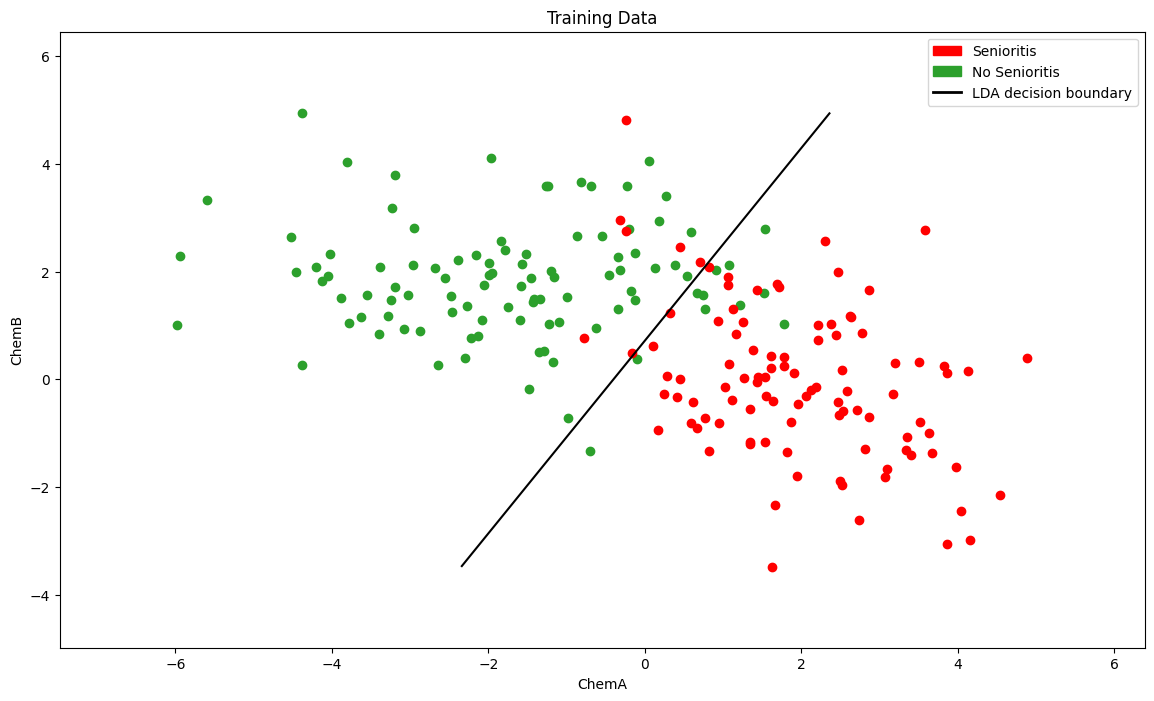

In [30]:
## Now for LDA Classifier, we know that decision boundary corresponds to
## following equation :-
##
## (xT @ inv(C) @ m0) + (-1/2)*(m0T @ inv(C) @ m0) + ln(π0)
## ><
## (xT @ inv(C) @ m1) + (-1/2)*(m1T @ inv(C) @ m1) + ln(π1)
##
## here xT is the variable factor. For two dimensional feature
## that is p=2, the above equation will reduce as :-
##
## Term1 A (Vector) := inv(C) @ mj
## Term2 B (Scaler) := (-1/2)*(mjT @ inv(C) @ mj)
## Term3 C (Scaler) := ln(πj)
## 
## y = A0*x1 + A1*x2 + B + C = 0
##
##
## The decision boundary for the above equation
## will correspond to a contour plot for equation
## y = 0

label_order = ["No Senioritis","Senioritis"]
feature_order = ["ChemA","ChemB"]
res_col = "ClassLabel"

C = estimate_common_covariance_matrix(df_train,res_col)
mean_matrix = estimate_mean_vectors(df_train,res_col)
prior_prob = estimate_prior_probability(df_train,res_col)

def LDA_equation(x,C=C,mean_matrix=mean_matrix,prior_prob=prior_prob):    
    pmf = []
    C_inv = np.linalg.inv(C)
    for label in label_order:
        ans = 0
        mj = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
        πj = prior_prob.loc[label]

        ans += np.linalg.multi_dot([x.transpose(), C_inv, mj])
        ans += (-0.5)*np.linalg.multi_dot([mj.transpose(), C_inv, mj])
        ans += np.log(πj)

        pmf.append(ans)
    # z > 0 refers to class 0
    # z < 0 refers to class 1
    return (pmf[0].item() - pmf[1].item())

fig, ax = plt.subplots(figsize=(14,8))
ax.set_title("Training Data")
ax.set_xlabel("ChemA")
ax.set_ylabel("ChemB")

for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax.scatter(x,y,c=color) 

x1_min, x1_max = df_train.loc[:,feature_order[0]].min(), df_train.loc[:,feature_order[0]].max()
x2_min, x2_max = df_train.loc[:,feature_order[1]].min(), df_train.loc[:,feature_order[1]].max()

padding = 1.5
ax.set_xlim([x1_min - padding, x1_max + padding])
ax.set_ylim([x2_min - padding, x2_max + padding])

x1 = np.linspace(x1_min, x1_max, 700)
x2 = np.linspace(x2_min, x2_max, 700)
x1, x2 = np.meshgrid(x1,x2)
z = np.zeros_like(x1)

for i in range(len(x1)):
    for j in range(len(x1)):
        z[i][j] = LDA_equation(np.array([x1[i][j], x2[i][j]]).reshape(2,1))


ax.contour(x1,x2,z,levels=[0], colors="black")

green_patch = Patch(color="#ff0000", label="Senioritis")
red_patch = Patch(color="#2ca02c", label="No Senioritis")
decision = Line2D([0], [0], color='black', lw=2, label='LDA decision boundary')

plt.legend(handles=[green_patch, red_patch, decision], loc='upper right')
plt.show()

### (b)

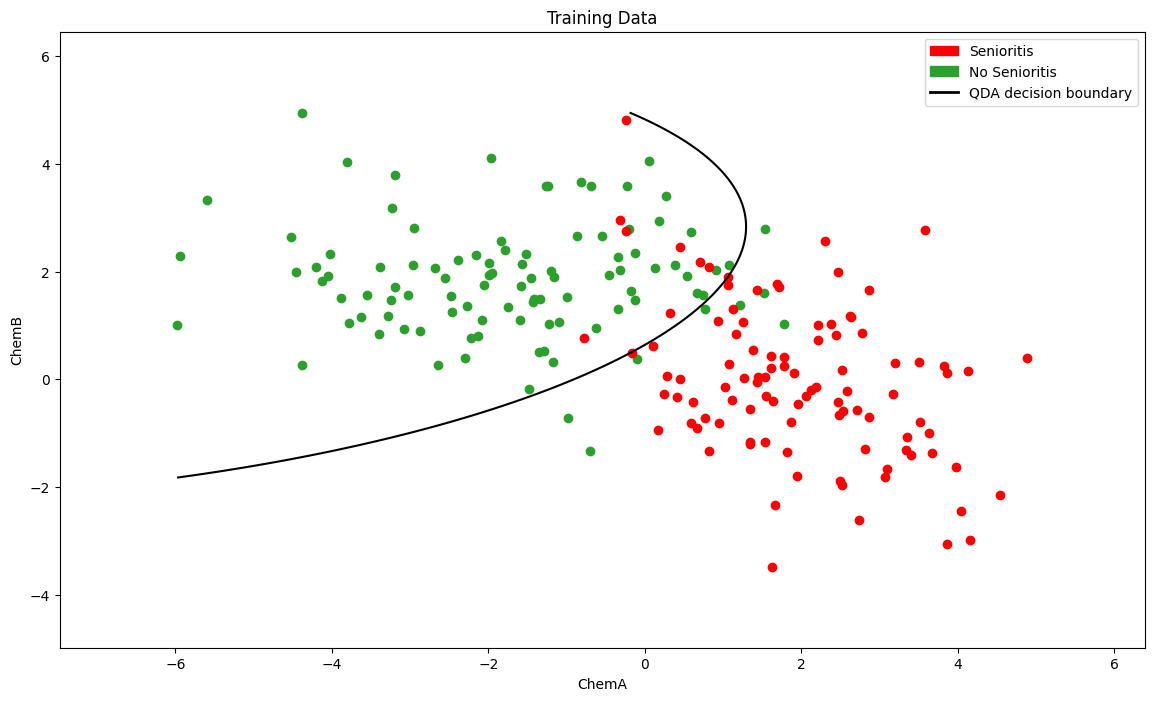

In [9]:
## Now for QDA Classifier, we know that decision boundary corresponds to
## following equation :-
##
## (-1/2)*(xT @ inv(C0) @ x) + (xT @ inv(C0) @ m0) + (-1/2)*(m0T @ inv(C0) @ m0) + (-1/2)*ln(Det(C0)) + ln(π0) 
## ><
## (-1/2)*(xT @ inv(C1) @ x) + (xT @ inv(C1) @ m1) + (-1/2)*(m1T @ inv(C1) @ m1) + (-1/2)*ln(Det(C1)) + ln(π1)
##
## here xT is the variable factor. For two dimensional feature
## that is p=2, the above equation will reduce as :-
##
## Term1 A (Vector) := (-1/2)*(inv(Cj))
## Term2 B (Vector) := inv(Cj) @ mj
## Term3 C := (-1/2)*(mjT @ inv(C) @ mj)
## Term4 D := (-1/2)*ln(Det(Cj))
## Term5 E := ln(πj)
## 
## A1x1^2 + A2x2^2 + B1x1 + B2x2 + C + D + E = y
##
## The decision boundary for the above equation
## will correspond to a contour plot for equation
## y = 0

label_order = ["No Senioritis","Senioritis"]
feature_order = ["ChemA","ChemB"]
res_col = "ClassLabel"

C = estimate_covariance_matrices(df_train,res_col)
mean_matrix = estimate_mean_vectors(df_train,res_col)
prior_prob = estimate_prior_probability(df_train,res_col)

def QDA_equation(x,C=C,mean_matrix=mean_matrix,prior_prob=prior_prob): 
    pmf = []
    for label in label_order:
        ans = 0
        mj = mean_matrix.loc[label][feature_order].to_numpy().reshape(2,1)
        πj = prior_prob.loc[label]
        Cj_inv = np.linalg.inv(C.loc[label])

        ans += (-0.5)*np.linalg.multi_dot([x.transpose(), Cj_inv, x])
        ans += np.linalg.multi_dot([x.transpose(), Cj_inv, mj])
        ans += (-0.5)*np.linalg.multi_dot([mj.transpose(), Cj_inv, mj])
        ans += (-0.5)*np.log(np.linalg.det(C.loc[label]))
        ans += np.log(πj)

        pmf.append(ans)
    # z > 0 refers to class 0
    # z < 0 refers to class 1
    return (pmf[0].item() - pmf[1].item())

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Training Data")
ax.set_xlabel("ChemA")
ax.set_ylabel("ChemB")

for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax.scatter(x,y,c=color) 

x1_min, x1_max = df_train.loc[:,feature_order[0]].min(), df_train.loc[:,feature_order[0]].max()
x2_min, x2_max = df_train.loc[:,feature_order[1]].min(), df_train.loc[:,feature_order[1]].max()

padding = 1.5
ax.set_xlim([x1_min - padding, x1_max + padding])
ax.set_ylim([x2_min - padding, x2_max + padding])

x1 = np.linspace(x1_min, x1_max, 700)
x2 = np.linspace(x2_min, x2_max, 700)
x1, x2 = np.meshgrid(x1,x2)
z = np.zeros_like(x1)

for i in range(len(x1)):
    for j in range(len(x1)):
        z[i][j] = QDA_equation(np.array([x1[i][j], x2[i][j]]).reshape(2,1))


ax.contour(x1,x2,z,levels=[0], colors="black")

green_patch = Patch(color="#ff0000", label="Senioritis")
red_patch = Patch(color="#2ca02c", label="No Senioritis")
decision = Line2D([0], [0], color='black', lw=2, label='QDA decision boundary')

plt.legend(handles=[green_patch, red_patch, decision], loc='upper right')
plt.show()

### (c)

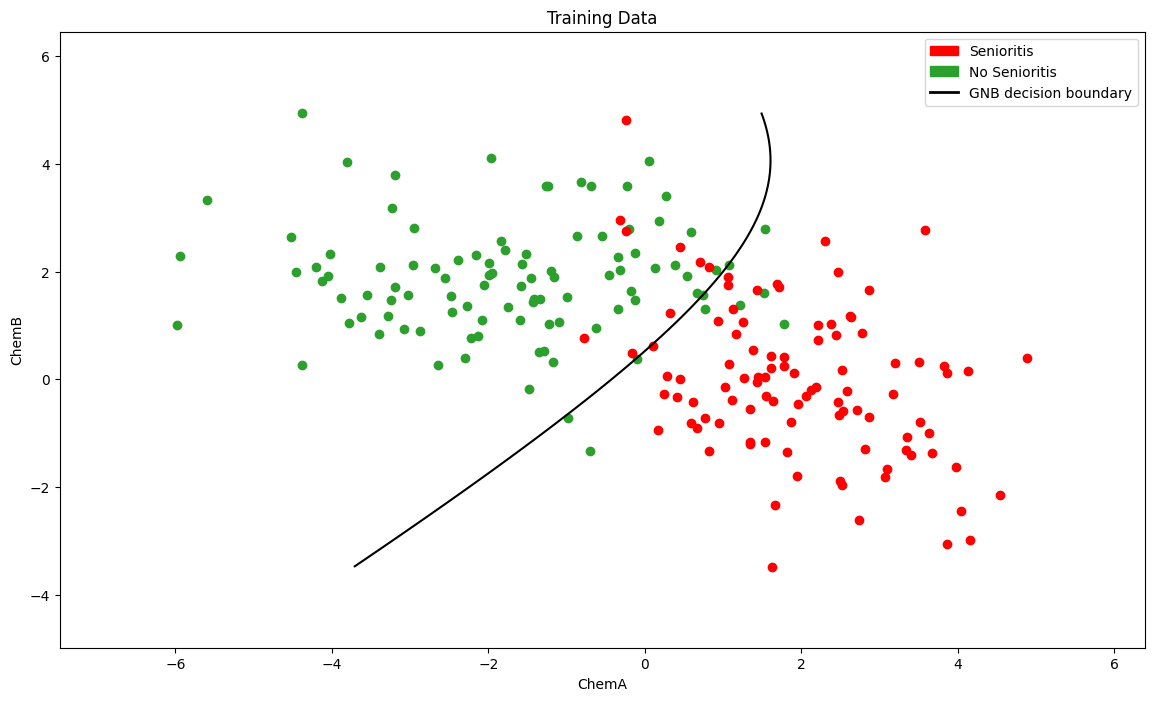

In [8]:
## Now for GNB Classifier, we know that decision boundary corresponds to
## following equation :-
##
## π0 * Px0(x / Y=0) * Px1(x / Y=0)
## ><
## π1 * Px0(x / Y=0) * Px1(x / Y=1)
##
## Here P is a Gaussian pmf, and so the equation will 
## reduce to :-
## 
## pmf0(x) - pmf1(x) = y
##
## The decision boundary for the above equation
## will correspond to a contour plot for equation
## y = 0

label_order = ["No Senioritis","Senioritis"]
feature_order = ["ChemA","ChemB"]
res_col = "ClassLabel"

C = estimate_var_vectors(df_train,res_col)
mean_matrix = estimate_mean_vectors(df_train,res_col)
prior_prob = estimate_prior_probability(df_train,res_col)

def GNB_equation(x,C=C,mean_matrix=mean_matrix,prior_prob=prior_prob): 
    pmf = []
    for label in label_order:
        πj = prior_prob.loc[label]
        inst = 1
        
        for i,feat in enumerate(feature_order):
            mk = mean_matrix.loc[label,feat]
            vk = C.loc[label,feat]
            inst *= plugin_gaussian_function(x[i].item(),mk,vk)

        pmf.append(πj*inst)
    # z > 0 refers to class 0
    # z < 0 refers to class 1
    return (pmf[0].item() - pmf[1].item())

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Training Data")
ax.set_xlabel("ChemA")
ax.set_ylabel("ChemB")

for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax.scatter(x,y,c=color) 

x1_min, x1_max = df_train.loc[:,feature_order[0]].min(), df_train.loc[:,feature_order[0]].max()
x2_min, x2_max = df_train.loc[:,feature_order[1]].min(), df_train.loc[:,feature_order[1]].max()

padding = 1.5
ax.set_xlim([x1_min - padding, x1_max + padding])
ax.set_ylim([x2_min - padding, x2_max + padding])

x1 = np.linspace(x1_min, x1_max, 700)
x2 = np.linspace(x2_min, x2_max, 700)
x1, x2 = np.meshgrid(x1,x2)
z = np.zeros_like(x1)

for i in range(len(x1)):
    for j in range(len(x1)):
        z[i][j] = GNB_equation(np.array([x1[i][j], x2[i][j]]).reshape(2,1))


ax.contour(x1,x2,z,levels=[0], colors="black")

green_patch = Patch(color="#ff0000", label="Senioritis")
red_patch = Patch(color="#2ca02c", label="No Senioritis")
decision = Line2D([0], [0], color='black', lw=2, label='GNB decision boundary')

plt.legend(handles=[green_patch, red_patch, decision], loc='upper right')
plt.show()

### (d)

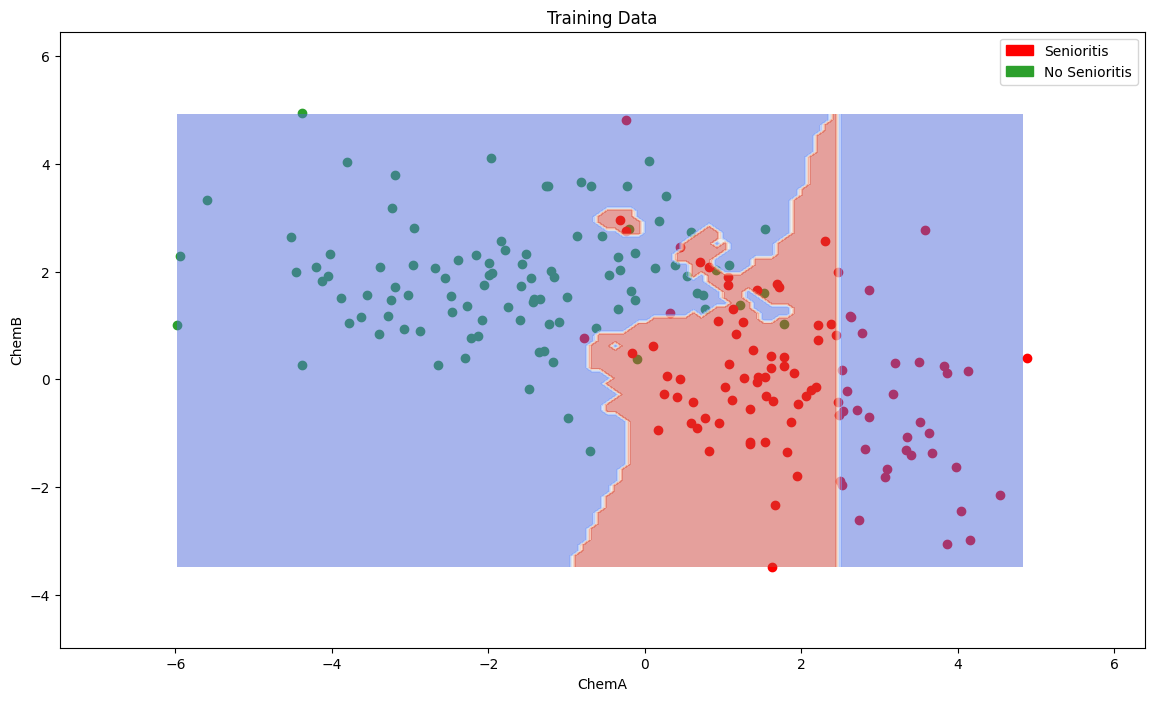

In [61]:
## Now for KNN Classifier, we dont have any equation
## and just the outputed label and so to plot the 
## decision boundary for KNN, we will plot contour 
## fills for the meshgrid
##

label_order = ["No Senioritis","Senioritis"]
feature_order = ["ChemA","ChemB"]
res_col = "ClassLabel"

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Training Data")
ax.set_xlabel("ChemA")
ax.set_ylabel("ChemB")

for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax.scatter(x,y,c=color) 

x1_min, x1_max = df_train.loc[:,feature_order[0]].min(), df_train.loc[:,feature_order[0]].max()
x2_min, x2_max = df_train.loc[:,feature_order[1]].min(), df_train.loc[:,feature_order[1]].max()

padding = 1.5
ax.set_xlim([x1_min - padding, x1_max + padding])
ax.set_ylim([x2_min - padding, x2_max + padding])

x1, x2 = np.meshgrid(np.arange(x1_min,x1_max,0.1),np.arange(x2_min,x2_max,0.1))
z = np.zeros_like(x1)

for i in range(len(x1)):
    for j in range(len(x1)):
        df = pd.DataFrame(np.array([x1[i][j], x2[i][j]]).reshape(1,2),columns=feature_order)
        res = classifier_KNN(df_train,3,df)
        z[i][j] = 0 if res.iloc[0]=="No Senioritis" else 1


ax.contourf(x1,x2,z,alpha=0.5, cmap=plt.cm.coolwarm)

green_patch = Patch(color="#ff0000", label="Senioritis")
red_patch = Patch(color="#2ca02c", label="No Senioritis")

plt.legend(handles=[green_patch, red_patch], loc='upper right')
plt.show()

### (e)

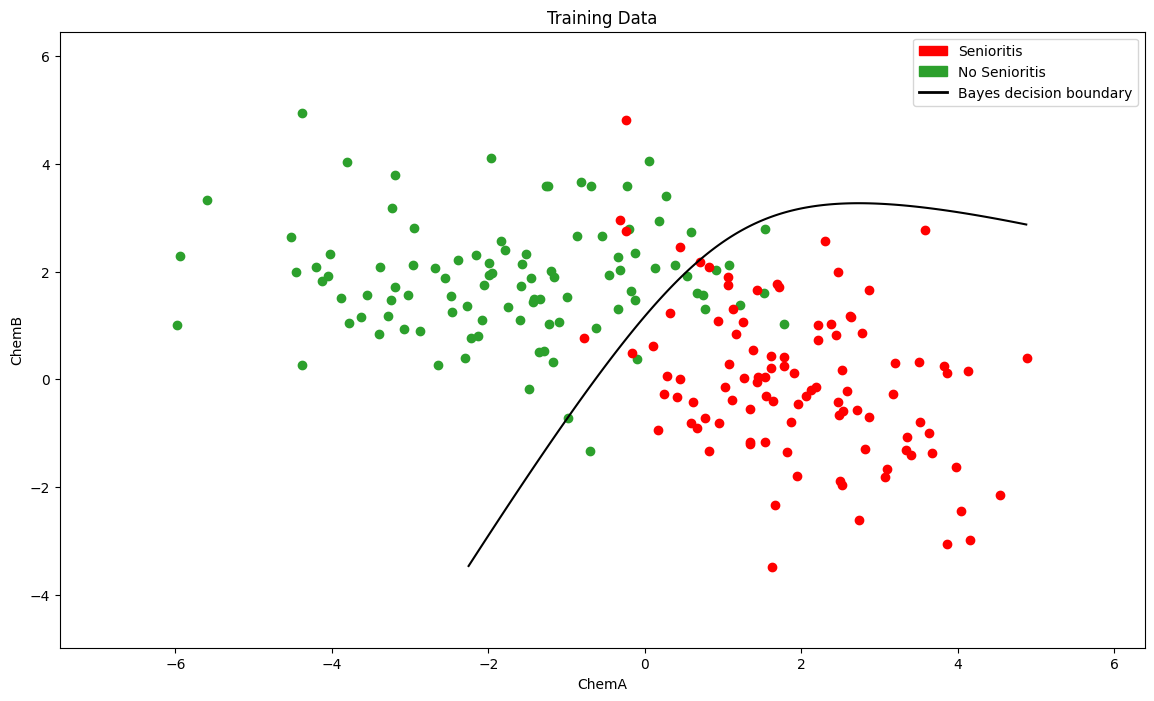

In [21]:
## Now for the given idead Bayes' classifier we know that 
## it corresponds to QDA classifier but with known mean vectors
## and covariance matrices.
##
## Using the known parameters we will apply the same function
## as QDA_equation but with known parameters
##
## The decision boundary will correspond to a contour plot for equation
## y = 0

label_order = ["No Senioritis","Senioritis"]
feature_order = ["ChemA","ChemB"]
res_col = "ClassLabel"

## Given parameters
C = pd.Series([np.array([[3, 0], [0, 1]]).reshape(2,2),
               np.array([[2, -1], [-1, 2]]).reshape(2,2)],index=label_order)
mean_matrix = pd.DataFrame(np.array([[-2, 2],[2,0]]).reshape(2,2),columns=feature_order,index=label_order)

prior_prob = estimate_prior_probability(df_train,res_col)

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Training Data")
ax.set_xlabel("ChemA")
ax.set_ylabel("ChemB")

for label in class_labels:
    x = groupby_train.get_group(label)["ChemA"]
    y = groupby_train.get_group(label)["ChemB"]
    color = "#2ca02c" if label=="No Senioritis" else "#ff0000"
    ax.scatter(x,y,c=color) 

x1_min, x1_max = df_train.loc[:,feature_order[0]].min(), df_train.loc[:,feature_order[0]].max()
x2_min, x2_max = df_train.loc[:,feature_order[1]].min(), df_train.loc[:,feature_order[1]].max()

padding = 1.5
ax.set_xlim([x1_min - padding, x1_max + padding])
ax.set_ylim([x2_min - padding, x2_max + padding])

x1 = np.linspace(x1_min, x1_max, 700)
x2 = np.linspace(x2_min, x2_max, 700)
x1, x2 = np.meshgrid(x1,x2)
z = np.zeros_like(x1)

for i in range(len(x1)):
    for j in range(len(x1)):
        z[i][j] = QDA_equation(np.array([x1[i][j], x2[i][j]]).reshape(2,1),C=C,mean_matrix=mean_matrix)


ax.contour(x1,x2,z,levels=[0], colors="black")

green_patch = Patch(color="#ff0000", label="Senioritis")
red_patch = Patch(color="#2ca02c", label="No Senioritis")
decision = Line2D([0], [0], color='black', lw=2, label='Bayes decision boundary')

plt.legend(handles=[green_patch, red_patch, decision], loc='upper right')
plt.show()

## Problem 1.6


### (a)

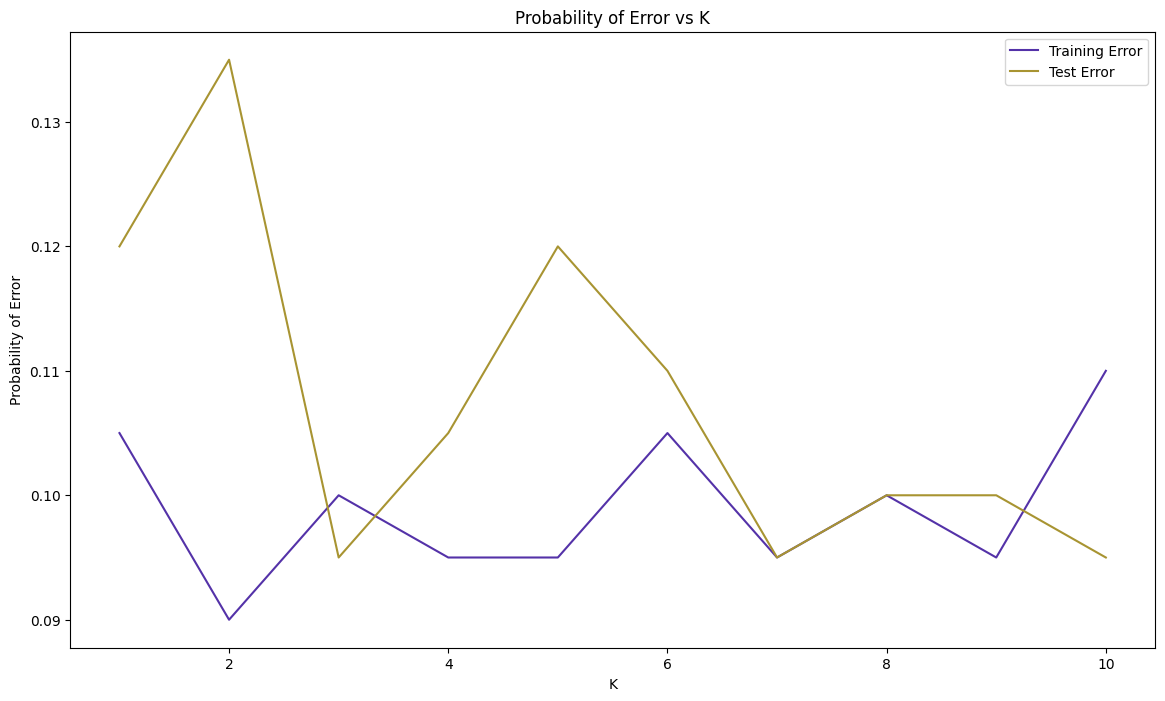

In [55]:
train_error = []
test_error  = []
K = 10

actual_train = df_train.loc[:,"ClassLabel"]
actual_test  = df_train.loc[:,"ClassLabel"]

for k in range(1,K+1):
    predicted_train = classifier_KNN(df_train, k)
    predicted_test  = classifier_KNN(df_train, k, df_test)

    train_error.append((predicted_train!=actual_train).sum() / len(df_train))
    test_error.append((predicted_test!=actual_test).sum() / len(df_test))

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Probability of Error vs K")
ax.set_xlabel("K")
ax.set_ylabel("Probability of Error")

ax.plot(range(1,K+1),train_error,color="#5432a8")
ax.plot(range(1,K+1),test_error,color="#a89432")

ax.legend(["Training Error","Test Error"])
plt.show()

### (b)

From the above plot we can observe that around **K=7** both training error and test error are low and nearly identical and after that point training error seems to increase and test error seems to decrease and so this point can be point be considered the divergence point for training error and test error, and thus **K=7** could be an optimal choice for the given data for implementing KNN classifier.